# Synthetic Data Results

In this file, we contain all the code for the creation and analysis of synthetic data used in our paper.

We generate our ground truth graphs through two methods
1) Erdos-Renyi
2) Barabasi-Albert
    * Barabasi, A-L and Albert, R. 1999. Emergence of scaling in random networks. Science, 286 509-512.

Here, we generate two types of Synthetic Data:
1) Gaussian Copula Data
2) Non-Gaussian Copula Data

We generate data in two forms:
1) Matrix-variate data
2) (3-axis) Tensor-variate data

And we run two tests on it:
1) Runtime test
2) PR curve test

We compare the following 5 algorithms:
1) Our method with 50 principal components
2) GmGM
3) TeraLasso
4) EiGLasso (when applicable, i.e. matrices)
5) DNNLasso (when applicable, i.e. matrices)

In [25]:
# Random seed; we will always use 0 for our seed, feel free to change it!
SEED = 0

# Imports

In [26]:
# Standard library dependencies
import sys
import random
import time
#import warnings
from typing import Optional


# External dependencies
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
import scipy # for version name
from scipy import stats
from scipy.special import comb

# My code 
import GmGM

# Wrappers for prior work
import BiGLasso_Methods as bg

In [27]:
print(f"Python version:\n\t{sys.version}\n--\n")
print(f"Numpy version: {np.__version__}")
print(f"igraph version: {ig.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Scipy version: {scipy.__version__}")
print(f"GmGM version: {GmGM.__version__}")
print(f"BiGLasso_Methods version: {bg.__version__}")

Python version:
	3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:53:08) 
[Clang 15.0.7 ]
--

Numpy version: 1.25.2
igraph version: 0.11.3
Matplotlib version: 3.8.0
Scipy version: 1.12.0
GmGM version: 0.5.3
BiGLasso_Methods version: 1.0.0


In [28]:
# Make palette colorblind friendly
plt.style.use('tableau-colorblind10')
hatches = ['|', '//', 'oo', 'x', '+', '-', 'OO', '.', '*', '\\']
lines = ['-', '--', '-.', ':', (0, (3, 5, 1, 5, 1, 5))]

# Building Blocks

This section contains examples and demonstrations of how we generate our data, run our tests, and validate that the tests and generation are done correctly.  Skip down to the "**Experiments**" section to see the actual tests get run.

## Generate Graphs

### Code used for Generation

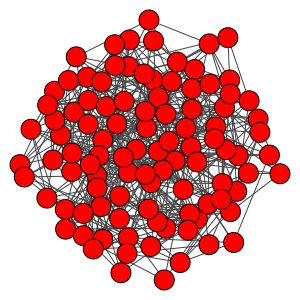

In [29]:
random.seed(SEED)
graph = ig.Graph.Erdos_Renyi(n=100, p=0.1)

# Display graph
ig.plot(graph, bbox=(0, 0, 300, 300))

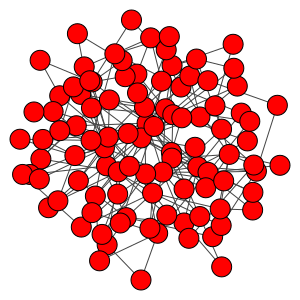

In [30]:
random.seed(SEED)
graph = ig.Graph.Barabasi(100, 2)

# Display graph
ig.plot(graph, bbox=(0, 0, 300, 300))

### Validate Graphs

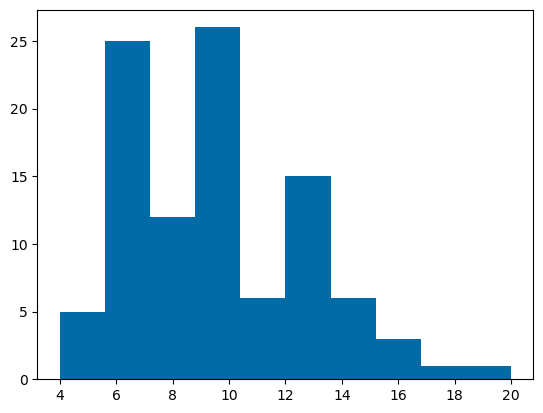

In [31]:
# Check degree distribution of Erdos-Renyi graph
random.seed(SEED)
graph = ig.Graph.Erdos_Renyi(n=100, p=0.1)
plt.hist(graph.degree())
pass

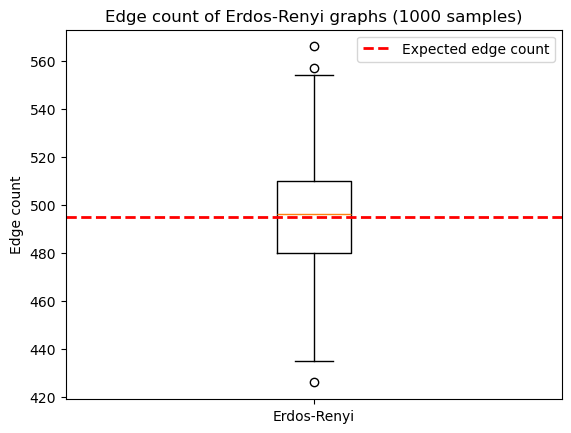

In [32]:
# Check edge count
# Should be (n choose 2) * p on average
random.seed(SEED)

ecounts = []
for i in range(1000):
    graph = ig.Graph.Erdos_Renyi(n=100, p=0.1)
    ecounts.append(graph.ecount())
average_amount = comb(100, 2) * 0.1

# Box and whisker plot
fig, ax = plt.subplots()
ax.boxplot(ecounts)
ax.axhline(average_amount, color='r', linestyle='dashed', linewidth=2, label='Expected edge count')
ax.set_xticklabels(['Erdos-Renyi'])
ax.set_ylabel('Edge count')
ax.set_title('Edge count of Erdos-Renyi graphs (1000 samples)')
ax.legend()
pass

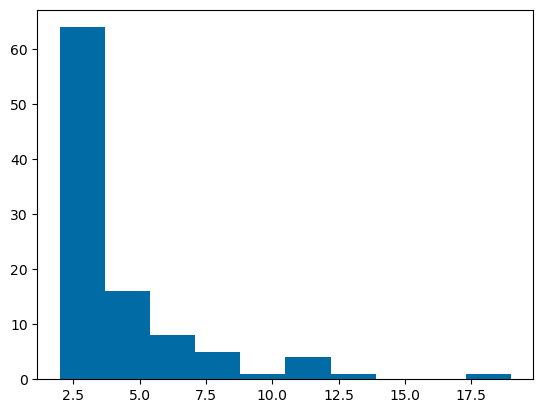

In [33]:
# Check degree distribution of Barabasi-Albert graph
random.seed(SEED)
graph = ig.Graph.Barabasi(100, 2)
plt.hist(graph.degree())
pass

## Generate Data

### Code used for generation

In [34]:
random.seed(SEED)
num_nodes = 5
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
adj_mat = np.array(graph.get_adjacency().data)

# Add diagonal so that it forms a PSD matrix!
adj_mat = adj_mat / 1.1 + np.eye(num_nodes)

adj_mat

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.90909091, 0.        , 0.        ],
       [0.        , 0.90909091, 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.90909091],
       [0.        , 0.        , 0.        , 0.90909091, 1.        ]])

In [35]:
# Helper functions to compute fast Kronecker sum
def kron_sum_diag_fast(
    *lams: list[np.ndarray]
) -> np.ndarray:
    # Setup
    ds = [len(lam) for lam in lams]
    d_lefts = np.cumprod([1] + ds[:-1]).astype(int)
    d_rights = np.cumprod([1] + ds[::-1])[-2::-1].astype(int)
    total = d_rights[0] * ds[0]
    out = np.zeros(total)
    
    
    for ell, lam in enumerate(lams):
        add_like_kron_sum(
            out,
            lam,
            ds[ell],
            d_lefts[ell],
            d_rights[ell]
        )
        
    return out

def add_like_kron_sum(
    cur_kron_sum: np.ndarray,
    to_add: np.ndarray,
    d: int,
    d_left: int,
    d_right: int
) -> None:
    """
    !!!!Modifies cur_kron_sum in place!!!!
    
    Let X[+]Y be the Kronecker sum
    of diagonal matrices.
    Sometimes we want to find X[+](Y+Z)
    for diagonal Z
    
    This is a way to update our pre-computed
    X[+]Y to incorporate the additive Z.

    Old typing hint:
        cur_kron_sum: "Kronsummed matrix",
        to_add: "What to add to matrix",
        ell: "Dimension to add along",
        d, d_left, d_right
    """
    # We're gonna be really naughty here and use stride_tricks
    # This is going to reshape our vector in a way so that the elements
    # we want to affect are batched by the first two dimensions
    sz = to_add.strides[0]
    toset = np.lib.stride_tricks.as_strided(
        cur_kron_sum,
        shape=(
            d_left, # The skips
            d_right, # The blocks
            d # What we want
        ),
        strides=(
            sz * d * d_right,
            sz * 1,
            sz * d_right,
        )
    )
    toset += to_add

In [36]:
def fast_kronecker_normal(
    Psis: list[np.ndarray],
    size: int,
    fail_if_not_posdef: bool = False,
    mean: np.array = None,
) -> np.ndarray:
    """
    Inputs:
        Psis: List of (d_i, d_i) precision matrices, of length K >= 2
        size: Number of samples
        fail_if_not_posdef:
            If True, raise Exception if any of the Psis is not positive definite
        mean: Mean of the distribution

    Outputs:
        Xs: Sample of Kronecker sum structured normal distribution
    """


    K = len(Psis)
    ds = [Psi.shape[0] for Psi in Psis]
    vs, Vs = zip(*[np.linalg.eigh(Psi) for Psi in Psis])
    diag_precisions = kron_sum_diag_fast(*vs)
    
    # Check if positive definite
    min_diag = diag_precisions.min()
    if min_diag < 0:
        if fail_if_not_posdef:
            raise Exception("KS of Psis not Positive Definite")
        diag_precisions -= (min_diag-1)
    
    # Sample from diagonalized, vectorized distribution
    z = stats.multivariate_normal(cov=1).rvs(
        size=size*np.prod(ds)
    ).reshape(size, np.prod(ds)) / np.sqrt(diag_precisions)
    
    # Reshape into a tensor
    Xs: np.ndarray = z.reshape(size, *ds)
    
    # Undiagonalize the distribution
    for k in range(K):
        Xs = np.moveaxis(
            np.moveaxis(Xs, k+1, -1) @ Vs[k].T,
            -1,
            k+1
        )

    if mean is not None:
        Xs += mean.reshape(1, *ds)

    return Xs

In [37]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 10
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
adj_mat = np.array(graph.get_adjacency().data)

# Add diagonal so that it forms a PSD matrix!
adj_mat = adj_mat / 1.1 + np.eye(num_nodes)

output = fast_kronecker_normal(
    [adj_mat, adj_mat],
    1
)[0]
output

array([[-5.16729084e-01, -3.23995949e-02,  8.07415424e-01,
        -7.05629700e-03, -8.58171350e-01, -1.29345123e+00,
        -5.35237854e-01,  4.11252216e-01,  2.71313042e-04,
         2.31112446e-01],
       [ 5.06944638e-02,  7.29046523e-02, -7.72049179e-01,
        -3.89794393e-01,  3.26372470e-01, -3.61078084e-01,
         4.17298380e-01, -5.64495806e-02, -2.19661053e-01,
        -1.87451710e-01],
       [-2.66704987e-02,  1.37545421e-02, -2.60104083e-01,
        -3.63625057e-01,  3.84825899e-01,  1.63454829e-01,
        -7.90315789e-01,  5.00726528e-01,  1.43901324e-01,
        -1.51588188e-01],
       [ 3.46416479e-01,  9.01922346e-01,  3.79101295e-01,
         2.12936051e-01, -6.43866994e-01, -4.02657194e-01,
        -4.69676413e-01,  7.13446239e-01,  3.34047878e-01,
         2.57595543e-01],
       [ 1.25836638e+00, -8.25000768e-01, -1.10844559e-01,
        -5.51490096e-01,  5.64844987e-01,  3.43246072e-01,
         3.18376680e-01, -7.84961125e-01,  5.35587322e-01,
        -5.

In [38]:
output = fast_kronecker_normal(
    [adj_mat, adj_mat],
    1
)
dataset = GmGM.Dataset(
    dataset={"data": output},
    structure={"data": ("", "rows", "columns")}
)
bg.GLasso(
    dataset,
    0.1,
    use_nonparanormal_skeptic=False
)

dataset.precision_matrices['columns'].toarray()

array([[ 4.20813509,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.90208804,  0.31391565,  0.        ,  0.        ],
       [ 0.        ,  3.55879208,  1.26145527,  0.        ,  0.        ,
         0.        , -0.28414372,  0.        , -0.15443655,  0.        ],
       [ 0.        ,  1.26145527,  3.30225077,  0.        ,  0.85263962,
        -0.42979425,  1.01128087,  0.2434747 ,  0.69450387,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  3.39728291,  0.59549278,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.85263962,  0.59549278,  3.40483253,
         0.        ,  0.        ,  0.        , -1.03924326, -0.34663703],
       [ 0.        ,  0.        , -0.42979425,  0.        ,  0.        ,
         6.65595619,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.90208804, -0.28414372,  1.01128087,  0.        ,  0.        ,
         0.        ,  3.45057893,  0.        

## Test Data

In [48]:
def pr_curve(
    ground_truth: np.ndarray,
    output: np.ndarray,
    num_points: int = 100
) -> tuple[np.ndarray, np.ndarray]:
    """
    Inputs:
        ground_truth: Adjacency matrix of graph
        output: Output of algorithm
        num_points: Number of points to sample

    Outputs:
        (precisions, recalls): Precision-recall curve
    """
    # Setup
    precisions = np.zeros(num_points)
    recalls = np.zeros(num_points)
    thresholds = np.linspace(0, np.max(output), num_points)

    ground_truth = ground_truth != 0
    np.fill_diagonal(ground_truth, 0)

    # Iterate over thresholds
    for i, threshold in enumerate(thresholds):
        # Threshold output
        output_thresholded = (np.abs(output) > threshold).astype(int)
        np.fill_diagonal(output_thresholded, 0)

        # Calculate precision and recall
        true_positives = np.sum(output_thresholded * ground_truth)
        false_positives = np.sum(output_thresholded * (1 - ground_truth))
        false_negatives = np.sum((1 - output_thresholded) * ground_truth)

        if true_positives + false_positives == 0:
            precisions[i] = 1
            recalls[i] = 0
        else:
            precisions[i] = true_positives / (true_positives + false_positives)
            recalls[i] = true_positives / (true_positives + false_negatives)

    return precisions, recalls

def pr_curve_teralasso(
    ground_truth: np.ndarray,
    alg: callable,
    reg_params: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """
    Inputs:
        ground_truth: Adjacency matrix of graph
        output: Output of algorithm
        num_points: Number of points to sample

    Outputs:
        (precisions, recalls): Precision-recall curve
    """
    # Setup
    precisions = np.zeros(reg_params.shape[0])
    recalls = np.zeros(reg_params.shape[0])
    #thresholds = np.linspace(0, np.max(output), num_points)

    ground_truth = ground_truth != 0
    np.fill_diagonal(ground_truth, 0)

    # Iterate over reg_params
    for i, param in enumerate(reg_params):
        # Threshold output
        print(f"TeraLasso lambda: {param}")
        output = alg(param)
        output_thresholded = (output != 0).astype(int)
        np.fill_diagonal(output_thresholded, 0)

        # Calculate precision and recall
        true_positives = np.sum(output_thresholded * ground_truth)
        false_positives = np.sum(output_thresholded * (1 - ground_truth))
        false_negatives = np.sum((1 - output_thresholded) * ground_truth)

        if true_positives + false_positives == 0:
            precisions[i] = 1
            recalls[i] = 0
        else:
            precisions[i] = true_positives / (true_positives + false_positives)
            recalls[i] = true_positives / (true_positives + false_negatives)

    return precisions, recalls

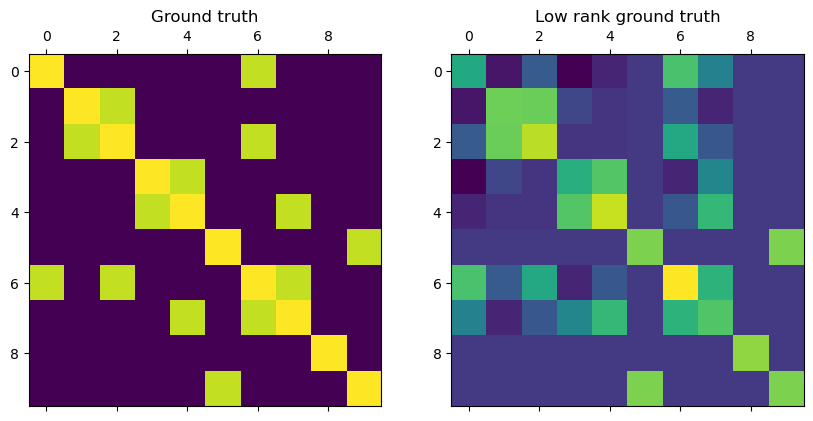

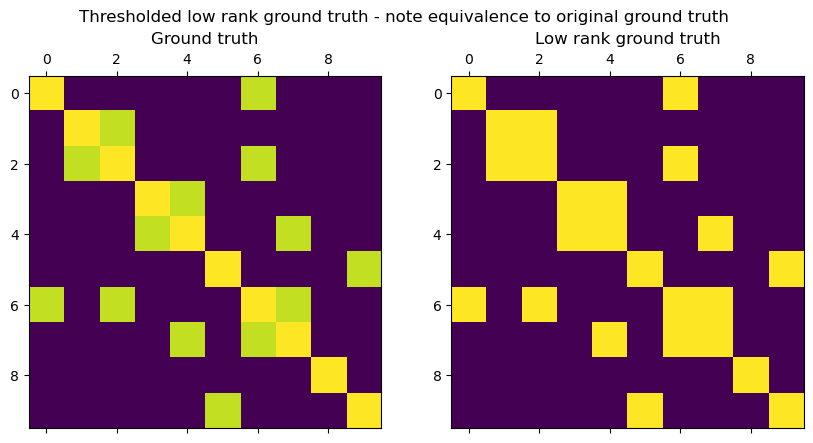

In [40]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 10
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
ground_truth = np.array(graph.get_adjacency().data)
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)
evals, evecs = np.linalg.eigh(ground_truth)

# Keep only top half
ground_truth_low_rank = evecs[:, -num_nodes//2:] @ np.diag(evals[-num_nodes//2:]) @ evecs[:, -num_nodes//2:].T

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.matshow(ground_truth)
ax1.set_title("Ground truth")
ax2.matshow(ground_truth_low_rank)
ax2.set_title("Low rank ground truth")

for (i, j), z in np.ndenumerate(ground_truth_low_rank):
    ax.text(
        j,
        i,
        '{:0.1f}'.format(z),
        ha='center',
        va='center',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
    )

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.matshow(ground_truth)
ax1.set_title("Ground truth")
ax2.matshow(ground_truth_low_rank > 0.5)
ax2.set_title("Low rank ground truth")
fig.suptitle("Thresholded low rank ground truth - note equivalence to original ground truth")
pass

# PR Curves

Running GmGM
	Trial 0 of 10
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM-125pcs
	Trial 0 of 10
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

	Trial 2 of 10
	Trial 3 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

	Trial 4 of 10
	Trial 5 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

	Trial 6 of 10
	Trial 7 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

	Trial 8 of 10
	Trial 9 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

Running GmGM-60pcs
	Trial 0 of 10
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

	Trial 2 of 10
	Trial 3 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 4 of 10
	Trial 5 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix i

	Trial 6 of 10
	Trial 7 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix i

	Trial 8 of 10
	Trial 9 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Running TeraLasso
	Trial 0 of 10
TeraLasso lambda: 0.0031622776601683794
TeraLasso lambda: 0.003831186849557289
TeraLasso lambda: 0.004641588833612777
TeraLasso lambda: 0.005623413251903491
TeraLasso lambda: 0.006812920690579615
TeraLasso lambda: 0.008254041852680182
TeraLasso lambda: 0.01
TeraLasso lambda: 0.012115276586285882
TeraLasso lambda: 0.01467799267622069
TeraLasso lambda: 0.01778279410038923
TeraLasso lambda: 0.021544346900318832
TeraLasso lambda: 0.026101572156825358
TeraLasso lambda: 0.03162277660168379
TeraLasso lambda: 0.03831186849557287
TeraLasso lambda: 0.046415888336127774
TeraLasso lambda: 0.05623413251903491
TeraLasso lambda: 0.06812920690579612
TeraLasso lambda: 0.08254041852680181
TeraLasso lambda: 0.1
TeraLasso lambda: 0.12115276586285882
TeraLasso lambda: 0.1467799267622069
TeraLasso lambda: 0.1778279410038923
TeraLasso lambda: 0.21544346900318834
TeraLasso lambda: 0.2610157215682536
TeraLasso lambda: 0.31622776601683794
	Trial 1 of 10
TeraLasso lambda: 0.00316

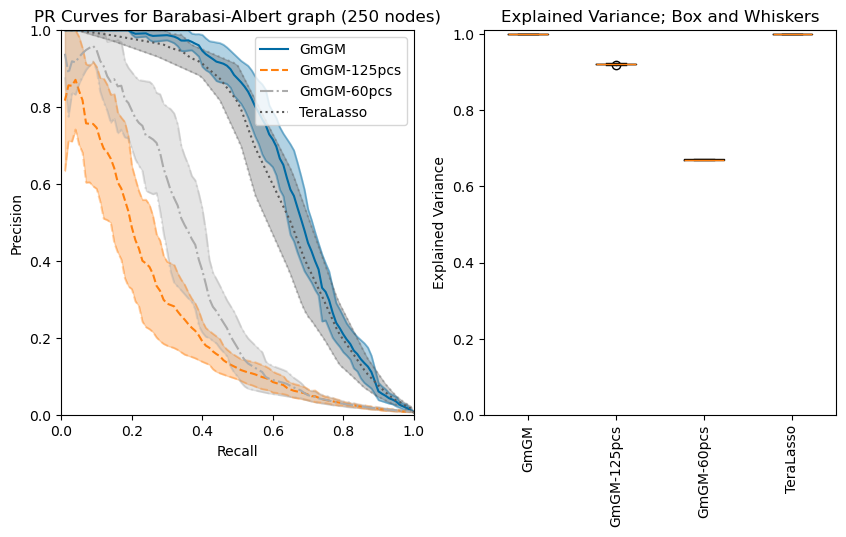

In [62]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 250
graph = ig.Graph.Barabasi(n=num_nodes)
ground_truth = np.array(graph.get_adjacency().data)
ranks = [125, 60]
colors = ["blue", "green"]

# Add diagonal so that it forms a PSD matrix!
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

evals, evecs = np.linalg.eigh(ground_truth)

# Keep only top half
ground_truth_low_rank = (
    evecs[:, -num_nodes//2:]
    @ np.diag(evals[-num_nodes//2:])
    @ evecs[:, -num_nodes//2:].T
)

explained_variances = {}

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))


algorithms = (
    ["GmGM"]
    + [f"GmGM-{rank}pcs" for rank in ranks]
    + ["TeraLasso"]
    #+ ["Graphical Lasso"]
)
for idx, algorithm in enumerate(algorithms):
    print(f"Running {algorithm}")
    ps = []
    rs = []

    explained_variances[algorithm] = []

    # Create a fake output
    num_trials = 10
    for i in range(num_trials):
        print(f"\tTrial {i} of {num_trials}")
        output = fast_kronecker_normal(
            [ground_truth_low_rank, ground_truth_low_rank],
            1
        )
        dataset = GmGM.Dataset(
            dataset={"data": output},
            structure={"data": ("", "rows", "columns")}
        )
        result = None
        run_alg = None
        if algorithm == "GmGM":
            result = GmGM.GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
            explained_variance = 1
        elif algorithm == "TeraLasso":
            def run_alg(reg_param):
                return bg.TeraLasso(
                    dataset,
                    reg_param,
                    use_nonparanormal_skeptic=False
                ).precision_matrices["rows"].toarray()
            explained_variance = 1
        elif algorithm == "DNNLasso":
            result = bg.DNNLasso(
                dataset,
                0,
                use_nonparanormal_skeptic=False
            )
            explained_variance = 1
        elif algorithm == "Graphical Lasso":
            result = bg.GLasso(
                dataset,
                0.1,
                use_nonparanormal_skeptic=False
            )
            explained_variance = 1
        elif algorithm == "GmGM-pcs":
            result = GmGM.GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=num_nodes // 2,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
            explained_variance = result.es["rows"].sum() / result.total_variance["rows"]
        else:
            for rank in ranks:
                if algorithm == f"GmGM-{rank}pcs":
                    result = GmGM.GmGM(
                        dataset,
                        to_keep=1,
                        threshold_method="overall-col-weighted",
                        min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                        n_comps=rank,
                        verbose=False,
                        centering_method=None,
                        use_nonparanormal_skeptic=False,
                        nonparanormal_evec_backend="COCA",
                        readonly=False,
                        calculate_explained_variance=True,
                        batch_size=1000
                    )
                    explained_variance = result.es["columns"].sum() / result.total_variance["columns"]
        if result is None and run_alg is None:
            raise Exception("Unknown algorithm")

        if algorithm != "TeraLasso":
            ys, xs = pr_curve(ground_truth, result.precision_matrices["rows"].toarray())
        else:
            # Manually chosen bounds to cover span from ~perfect recall to ~perfect precision
            reg_params = 10**np.linspace(-2.5, -0.5, 25)
            ys, xs = pr_curve_teralasso(ground_truth, run_alg, reg_params)
        ps.append(ys)
        rs.append(xs)
        #ax.plot(xs, ys)

        explained_variances[algorithm].append(explained_variance)

    num_points = 100
    xs = np.linspace(0, 1, num_points)

    if algorithm == "GmGM":
        label = "GmGM"
    elif algorithm == "GmGM-pcs":
        label = f"GmGM-{num_nodes//2}pcs"
    elif algorithm == "TeraLasso":
        label = "TeraLasso"
    elif algorithm == "DNNLasso":
        label = "DNNLasso"
    elif algorithm == "Graphical Lasso":
        label = "Graphical Lasso"
    else:
        for col, rank in zip(colors, ranks):
            if algorithm == f"GmGM-{rank}pcs":
                label = f"GmGM-{rank}pcs"

    lineplot = ax1.plot(-1, -1)#, label=label)
    xs = np.linspace(0.01, 1, 100)
    min_ys = np.zeros(100) + 1
    max_ys = np.zeros(100)
    for p, r in zip(ps, rs):
        f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
        min_ys = np.minimum(min_ys, f(xs))
        max_ys = np.maximum(max_ys, f(xs))
        #plt.plot(xs, f(xs), color='black', alpha=0.1)

    ax1.plot(
        xs,
        min_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        max_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        (min_ys + max_ys) / 2,
        color=lineplot[0].get_color(),
        label=label,
        linestyle=lines[idx]
    )
    ax1.fill_between(
        xs,
        min_ys,
        max_ys,
        color=lineplot[0].get_color(),
        alpha=0.3
    )#, hatch=hatches[idx]+hatches[idx])

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(f'PR Curves for Barabasi-Albert graph ({num_nodes} nodes)')
ax1.legend()

# On ax2, do a box-and-whiskers plot of explained variances
ax2.boxplot(
    [
        list(explained_variances["GmGM"]),
        #list(explained_variances["GmGM-pcs"])
    ]
    +
    [
        list(explained_variances[f"GmGM-{rank}pcs"])
        for rank in ranks
    ]
    +
    [
        list(explained_variances["TeraLasso"]),
        #list(explained_variances["Graphical Lasso"])
    ],
    labels=algorithms
)

ax2.set_title("Explained Variance; Box and Whiskers")
ax2.set_ylabel("Explained Variance")
ax2.set_ylim(0, 1.01)

# Rotate x-axis labels
ax2.tick_params(axis='x', labelrotation=90)
fig.savefig('./out-figs/250-nodes-pr.pdf', bbox_inches="tight")
pass

Running GmGM
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM-500pcs
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 2 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 3 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 4 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 5 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 6 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 7 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 8 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 9 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Running GmGM-125pcs
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 2 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 3 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 4 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 5 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 6 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 7 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 8 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 9 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


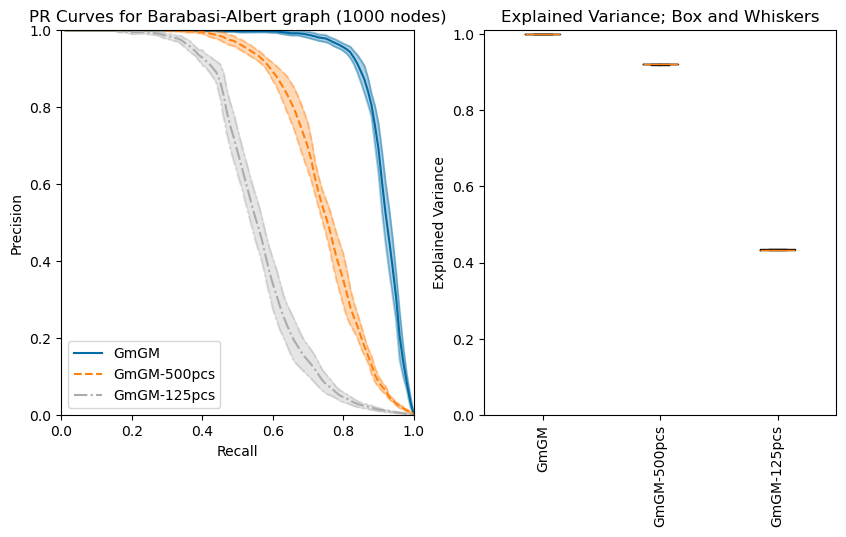

In [43]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 1000
graph = ig.Graph.Barabasi(n=num_nodes)
ground_truth = np.array(graph.get_adjacency().data)
ranks = [500, 125]
colors = ["blue", "green"]

# Add diagonal so that it forms a PSD matrix!
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

evals, evecs = np.linalg.eigh(ground_truth)

# Keep only top half
ground_truth_low_rank = (
    evecs[:, -num_nodes//2:]
    @ np.diag(evals[-num_nodes//2:])
    @ evecs[:, -num_nodes//2:].T
)

explained_variances = {}

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))


algorithms = (
    []#["TeraLasso"]
    + ["GmGM"]
    + [f"GmGM-{rank}pcs" for rank in ranks]
)
for idx, algorithm in enumerate(algorithms):
    print(f"Running {algorithm}")
    ps = []
    rs = []

    explained_variances[algorithm] = []

    # Create a fake output
    num_trials = 10
    for i in range(num_trials):
        print(f"\tTrial {i} of {num_trials}")
        output = fast_kronecker_normal(
            [ground_truth_low_rank, ground_truth_low_rank],
            1
        )
        dataset = GmGM.Dataset(
            dataset={"data": output},
            structure={"data": ("", "rows", "columns")}
        )
        result = None
        if algorithm == "GmGM":
            result = GmGM.GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
            explained_variance = 1
        elif algorithm == "TeraLasso":
            def run_teralasso(reg_param):
                return bg.TeraLasso(
                    dataset,
                    reg_param,
                    use_nonparanormal_skeptic=False
                )
            explained_variance = 1
        elif algorithm == "DNNLasso":
            result = bg.DNNLasso(
                dataset,
                0,
                use_nonparanormal_skeptic=False
            )
            explained_variance = 1
        elif algorithm == "GmGM-pcs":
            result = GmGM.GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=num_nodes // 2,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
            explained_variance = result.es["rows"].sum() / result.total_variance["rows"]
        else:
            for rank in ranks:
                if algorithm == f"GmGM-{rank}pcs":
                    result = GmGM.GmGM(
                        dataset,
                        to_keep=1,
                        threshold_method="overall-col-weighted",
                        min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                        n_comps=rank,
                        verbose=False,
                        centering_method=None,
                        use_nonparanormal_skeptic=False,
                        nonparanormal_evec_backend="COCA",
                        readonly=False,
                        calculate_explained_variance=True,
                        batch_size=1000
                    )
                    explained_variance = result.es["rows"].sum() / result.total_variance["rows"]
        if result is None:
            raise Exception("Unknown algorithm")
        
        if algorithm != "TeraLasso":
            ys, xs = pr_curve(ground_truth, result.precision_matrices["rows"].toarray())
        else:
            reg_params = np.linspace(0, np.max(result.precision_matrices["rows"].toarray()), 100)
            ys, xs = pr_curve_teralasso(ground_truth, run_teralasso, reg_params)
        ps.append(ys)
        rs.append(xs)
        #ax.plot(xs, ys)

        explained_variances[algorithm].append(explained_variance)

    num_points = 100
    xs = np.linspace(0, 1, num_points)

    if algorithm == "GmGM":
        label = "GmGM"
    elif algorithm == "GmGM-pcs":
        label = f"GmGM-{num_nodes//2}pcs"
    elif algorithm == "TeraLasso":
        label = "TeraLasso"
    elif algorithm == "DNNLasso":
        label = "DNNLasso"
    else:
        for col, rank in zip(colors, ranks):
            if algorithm == f"GmGM-{rank}pcs":
                label = f"GmGM-{rank}pcs"

    lineplot = ax1.plot(-1, -1)#, label=label)
    xs = np.linspace(0.01, 1, 100)
    min_ys = np.zeros(100) + 1
    max_ys = np.zeros(100)
    for p, r in zip(ps, rs):
        f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
        min_ys = np.minimum(min_ys, f(xs))
        max_ys = np.maximum(max_ys, f(xs))
        #plt.plot(xs, f(xs), color='black', alpha=0.1)

    ax1.plot(
        xs,
        min_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        max_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        (min_ys + max_ys) / 2,
        color=lineplot[0].get_color(),
        label=label,
        linestyle=lines[idx]
    )
    ax1.fill_between(
        xs,
        min_ys,
        max_ys,
        color=lineplot[0].get_color(),
        alpha=0.3
    )#, hatch=hatches[idx]+hatches[idx])

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(f'PR Curves for Barabasi-Albert graph ({num_nodes} nodes)')
ax1.legend()

# On ax2, do a box-and-whiskers plot of explained variances
ax2.boxplot(
    [
        #list(explained_variances["TeraLasso"]),
        list(explained_variances["GmGM"]),
        #list(explained_variances["GmGM-pcs"])
    ]
    +
    [
        list(explained_variances[f"GmGM-{rank}pcs"])
        for rank in ranks
    ],
    labels=algorithms
)

ax2.set_title("Explained Variance; Box and Whiskers")
ax2.set_ylabel("Explained Variance")
ax2.set_ylim(0, 1.01)

# Rotate x-axis labels
ax2.tick_params(axis='x', labelrotation=90)

pass

Running GmGM
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM-500pcs
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 2 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 3 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 4 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 5 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 6 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 7 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 8 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 9 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Running GmGM-125pcs
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 2 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 3 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 4 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 5 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 6 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 7 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 8 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 9 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


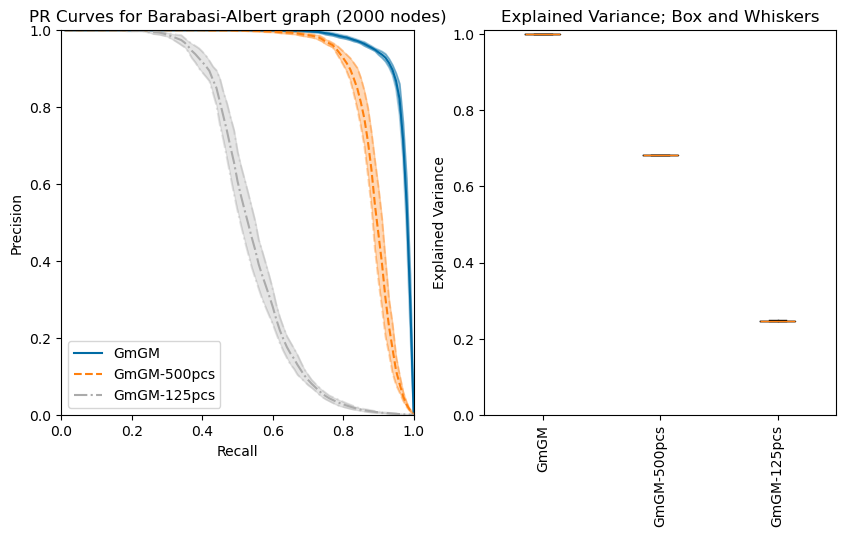

In [44]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 2000
graph = ig.Graph.Barabasi(n=num_nodes)
ground_truth = np.array(graph.get_adjacency().data)
ranks = [500, 125]
colors = ["blue", "green"]

# Add diagonal so that it forms a PSD matrix!
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

evals, evecs = np.linalg.eigh(ground_truth)

# Keep only top half
ground_truth_low_rank = (
    evecs[:, -num_nodes//2:]
    @ np.diag(evals[-num_nodes//2:])
    @ evecs[:, -num_nodes//2:].T
)

explained_variances = {}

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))


algorithms = (
    ["GmGM"]
    + [f"GmGM-{rank}pcs" for rank in ranks]
    # + ["Graphical Lasso"]
)
for idx, algorithm in enumerate(algorithms):
    print(f"Running {algorithm}")
    ps = []
    rs = []

    explained_variances[algorithm] = []

    # Create a fake output
    num_trials = 10
    for i in range(num_trials):
        print(f"\tTrial {i} of {num_trials}")
        output = fast_kronecker_normal(
            [ground_truth_low_rank, ground_truth_low_rank],
            1
        )
        dataset = GmGM.Dataset(
            dataset={"data": output},
            structure={"data": ("", "rows", "columns")}
        )
        result = None
        if algorithm == "GmGM":
            result = GmGM.GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
            explained_variance = 1
        elif algorithm == "TeraLasso":
            result = bg.TeraLasso(
                dataset,
                0,
                use_nonparanormal_skeptic=False
            )
            explained_variance = 1
        elif algorithm == "DNNLasso":
            result = bg.DNNLasso(
                dataset,
                0,
                use_nonparanormal_skeptic=False
            )
            explained_variance = 1
        elif algorithm == "Graphical Lasso":
            result = bg.GLasso(
                dataset,
                0.0001,
                use_nonparanormal_skeptic=False
            )
            explained_variance = 1
        elif algorithm == "GmGM-pcs":
            result = GmGM.GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=num_nodes // 2,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
            explained_variance = result.es["columns"].sum() / result.total_variance["columns"]
        else:
            for rank in ranks:
                if algorithm == f"GmGM-{rank}pcs":
                    result = GmGM.GmGM(
                        dataset,
                        to_keep=1,
                        threshold_method="overall-col-weighted",
                        min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                        n_comps=rank,
                        verbose=False,
                        centering_method=None,
                        use_nonparanormal_skeptic=False,
                        nonparanormal_evec_backend="COCA",
                        readonly=False,
                        calculate_explained_variance=True,
                        batch_size=1000
                    )
                    explained_variance = result.es["columns"].sum() / result.total_variance["columns"]
        if result is None:
            raise Exception("Unknown algorithm")
        
        ys, xs = pr_curve(ground_truth, result.precision_matrices["columns"].toarray())
        ps.append(ys)
        rs.append(xs)
        #ax.plot(xs, ys)

        explained_variances[algorithm].append(explained_variance)

    num_points = 100
    xs = np.linspace(0, 1, num_points)

    if algorithm == "GmGM":
        label = "GmGM"
    elif algorithm == "GmGM-pcs":
        label = f"GmGM-{num_nodes//2}pcs"
    elif algorithm == "TeraLasso":
        label = "TeraLasso"
    elif algorithm == "DNNLasso":
        label = "DNNLasso"
    elif algorithm == "Graphical Lasso":
        label = "Graphical Lasso"
    else:
        for col, rank in zip(colors, ranks):
            if algorithm == f"GmGM-{rank}pcs":
                label = f"GmGM-{rank}pcs"

    lineplot = ax1.plot(-1, -1)#, label=label)
    xs = np.linspace(0.01, 1, 100)
    min_ys = np.zeros(100) + 1
    max_ys = np.zeros(100)
    for p, r in zip(ps, rs):
        f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
        min_ys = np.minimum(min_ys, f(xs))
        max_ys = np.maximum(max_ys, f(xs))
        #plt.plot(xs, f(xs), color='black', alpha=0.1)

    ax1.plot(
        xs,
        min_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        max_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        (min_ys + max_ys) / 2,
        color=lineplot[0].get_color(),
        label=label,
        linestyle=lines[idx]
    )
    ax1.fill_between(
        xs,
        min_ys,
        max_ys,
        color=lineplot[0].get_color(),
        alpha=0.3
    )#, hatch=hatches[idx]+hatches[idx])

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(f'PR Curves for Barabasi-Albert graph ({num_nodes} nodes)')
ax1.legend()

# On ax2, do a box-and-whiskers plot of explained variances
ax2.boxplot(
    [
        #list(explained_variances["TeraLasso"]),
        list(explained_variances["GmGM"]),
        #list(explained_variances["GmGM-pcs"])
    ]
    +
    [
        list(explained_variances[f"GmGM-{rank}pcs"])
        for rank in ranks
    # ]
    # +
    # [
    #     list(explained_variances["Graphical Lasso"])
    ],
    labels=algorithms
)

ax2.set_title("Explained Variance; Box and Whiskers")
ax2.set_ylabel("Explained Variance")
ax2.set_ylim(0, 1.01)

# Rotate x-axis labels
ax2.tick_params(axis='x', labelrotation=90)
fig.savefig('./out-figs/2000-nodes-pr.pdf', bbox_inches="tight")
pass

Running GmGM
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM-500pcs
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 2 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 3 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 4 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 5 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 6 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 7 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 8 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 9 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Running GmGM-125pcs
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 2 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 3 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 4 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 5 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 6 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 7 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 8 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 9 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


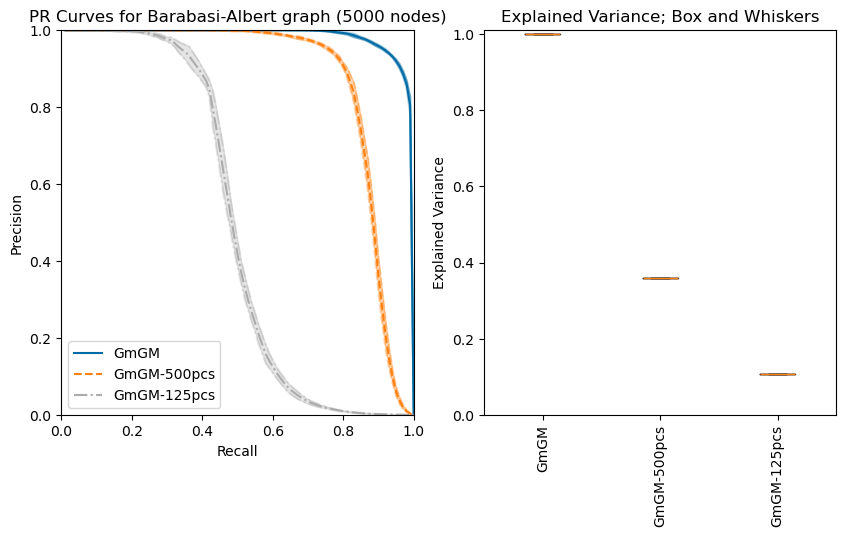

In [65]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 5000
graph = ig.Graph.Barabasi(n=num_nodes)
ground_truth = np.array(graph.get_adjacency().data)
ranks = [500, 125]
colors = ["blue", "green"]

# Add diagonal so that it forms a PSD matrix!
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

evals, evecs = np.linalg.eigh(ground_truth)

# Keep only top half
ground_truth_low_rank = (
    evecs[:, -num_nodes//2:]
    @ np.diag(evals[-num_nodes//2:])
    @ evecs[:, -num_nodes//2:].T
)

explained_variances = {}

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))


algorithms = (
    []#["TeraLasso"]
    + ["GmGM"]
    + [f"GmGM-{rank}pcs" for rank in ranks]
)
for idx, algorithm in enumerate(algorithms):
    print(f"Running {algorithm}")
    ps = []
    rs = []

    explained_variances[algorithm] = []

    # Create a fake output
    num_trials = 10
    for i in range(num_trials):
        print(f"\tTrial {i} of {num_trials}")
        output = fast_kronecker_normal(
            [ground_truth_low_rank, ground_truth_low_rank],
            1
        )
        dataset = GmGM.Dataset(
            dataset={"data": output},
            structure={"data": ("", "rows", "columns")}
        )
        result = None
        if algorithm == "GmGM":
            result = GmGM.GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
            explained_variance = 1
        elif algorithm == "TeraLasso":
            result = bg.TeraLasso(
                dataset,
                0,
                use_nonparanormal_skeptic=False
            )
            explained_variance = 1
        elif algorithm == "DNNLasso":
            result = bg.DNNLasso(
                dataset,
                0,
                use_nonparanormal_skeptic=False
            )
            explained_variance = 1
        elif algorithm == "GmGM-pcs":
            result = GmGM.GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=num_nodes // 2,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
            explained_variance = result.es["rows"].sum() / result.total_variance["rows"]
        else:
            for rank in ranks:
                if algorithm == f"GmGM-{rank}pcs":
                    result = GmGM.GmGM(
                        dataset,
                        to_keep=1,
                        threshold_method="overall-col-weighted",
                        min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                        n_comps=rank,
                        verbose=False,
                        centering_method=None,
                        use_nonparanormal_skeptic=False,
                        nonparanormal_evec_backend="COCA",
                        readonly=False,
                        calculate_explained_variance=True,
                        batch_size=1000
                    )
                    explained_variance = result.es["rows"].sum() / result.total_variance["rows"]
        if result is None:
            raise Exception("Unknown algorithm")
        
        ys, xs = pr_curve(ground_truth, result.precision_matrices["rows"].toarray())
        ps.append(ys)
        rs.append(xs)
        #ax.plot(xs, ys)

        explained_variances[algorithm].append(explained_variance)

    num_points = 100
    xs = np.linspace(0, 1, num_points)

    if algorithm == "GmGM":
        label = "GmGM"
    elif algorithm == "GmGM-pcs":
        label = f"GmGM-{num_nodes//2}pcs"
    elif algorithm == "TeraLasso":
        label = "TeraLasso"
    elif algorithm == "DNNLasso":
        label = "DNNLasso"
    else:
        for col, rank in zip(colors, ranks):
            if algorithm == f"GmGM-{rank}pcs":
                label = f"GmGM-{rank}pcs"

    lineplot = ax1.plot(-1, -1)#, label=label)
    xs = np.linspace(0.01, 1, 100)
    min_ys = np.zeros(100) + 1
    max_ys = np.zeros(100)
    for p, r in zip(ps, rs):
        f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
        min_ys = np.minimum(min_ys, f(xs))
        max_ys = np.maximum(max_ys, f(xs))
        #plt.plot(xs, f(xs), color='black', alpha=0.1)

    ax1.plot(
        xs,
        min_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        max_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        (min_ys + max_ys) / 2,
        color=lineplot[0].get_color(),
        label=label,
        linestyle=lines[idx]
    )
    ax1.fill_between(
        xs,
        min_ys,
        max_ys,
        color=lineplot[0].get_color(),
        alpha=0.3
    )#, hatch=hatches[idx]+hatches[idx])

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(f'PR Curves for Barabasi-Albert graph ({num_nodes} nodes)')
ax1.legend()

# On ax2, do a box-and-whiskers plot of explained variances
ax2.boxplot(
    [
        #list(explained_variances["TeraLasso"]),
        list(explained_variances["GmGM"]),
        #list(explained_variances["GmGM-pcs"])
    ]
    +
    [
        list(explained_variances[f"GmGM-{rank}pcs"])
        for rank in ranks
    ],
    labels=algorithms
)

ax2.set_title("Explained Variance; Box and Whiskers")
ax2.set_ylabel("Explained Variance")
ax2.set_ylim(0, 1.01)

# Rotate x-axis labels
ax2.tick_params(axis='x', labelrotation=90)
fig.savefig('./out-figs/5000-nodes-pr.pdf', bbox_inches="tight")
pass

Running GmGM
	Trial 0 of 10
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM-128pcs
	Trial 0 of 10
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

	Trial 2 of 10
	Trial 3 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

	Trial 4 of 10
	Trial 5 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

	Trial 6 of 10
	Trial 7 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

	Trial 8 of 10
	Trial 9 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

Running GmGM-64pcs
	Trial 0 of 10
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")


	Trial 2 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

	Trial 3 of 10
	Trial 4 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

	Trial 5 of 10
	Trial 6 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_no

	Trial 7 of 10
	Trial 8 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 9 of 10
Running TeraLasso
	Trial 0 of 10
TeraLasso lambda: 0.0031622776601683794
TeraLasso lambda: 0.003831186849557289
TeraLasso lambda: 0.004641588833612777
TeraLasso lambda: 0.005623413251903491
TeraLasso lambda: 0.006812920690579615
TeraLasso lambda: 0.008254041852680182
TeraLasso lambda: 0.01
TeraLasso lambda: 0.012115276586285882
TeraLasso lambda: 0.01467799267622069
TeraLasso lambda: 0.01778279410038923
TeraLasso lambda: 0.021544346900318832
TeraLasso lambda: 0.026101572156825358
TeraLasso lambda: 0.03162277660168379
TeraLasso lambda: 0.03831186849557287
TeraLasso lambda: 0.046415888336127774
TeraLasso lambda: 0.05623413251903491
TeraLasso lambda: 0.06812920690579612
TeraLasso lambda: 0.08254041852680181
TeraLasso lambda: 0.1
TeraLasso lambda: 0.12115276586285882
TeraLasso lambda: 0.1467799267622069
TeraLasso lambda: 0.1778279410038923
TeraLasso lambda: 0.21544346900318834
TeraLasso lambda: 0.2610157215682536
TeraLasso lambda: 0.31622776601683794
	Trial 1 of 10
TeraLasso 

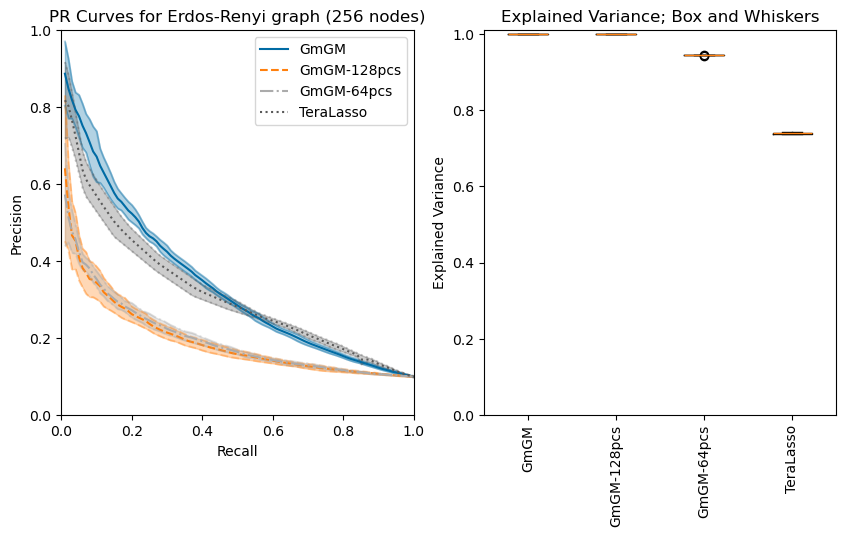

In [64]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 256
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
ground_truth = np.array(graph.get_adjacency().data)
ranks = [128, 64]
colors = ["blue", "green"]

# Add diagonal so that it forms a PSD matrix!
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

evals, evecs = np.linalg.eigh(ground_truth)

# Keep only top half
ground_truth_low_rank = (
    evecs[:, -num_nodes//2:]
    @ np.diag(evals[-num_nodes//2:])
    @ evecs[:, -num_nodes//2:].T
)

explained_variances = {}

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))


algorithms = (
    ["GmGM"]
    + [f"GmGM-{rank}pcs" for rank in ranks]
    + ["TeraLasso"]
)
for idx, algorithm in enumerate(algorithms):
    print(f"Running {algorithm}")
    ps = []
    rs = []

    explained_variances[algorithm] = []

    # Create a fake output
    num_trials = 10
    for i in range(num_trials):
        print(f"\tTrial {i} of {num_trials}")
        output = fast_kronecker_normal(
            [ground_truth_low_rank, ground_truth_low_rank],
            1
        )
        dataset = GmGM.Dataset(
            dataset={"data": output},
            structure={"data": ("", "rows", "columns")}
        )
        result = None
        run_alg = None
        if algorithm == "GmGM":
            result = GmGM.GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
            explained_variance = 1
        elif algorithm == "TeraLasso":
            def run_alg(reg_param):
                return bg.TeraLasso(
                    dataset,
                    reg_param,
                    use_nonparanormal_skeptic=False
                ).precision_matrices["rows"].toarray()
            explained_variance = 1
        elif algorithm == "DNNLasso":
            result = bg.DNNLasso(
                dataset,
                0,
                use_nonparanormal_skeptic=False
            )
            explained_variance = 1
        elif algorithm == "GmGM-pcs":
            result = GmGM.GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=num_nodes // 2,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
            explained_variance = result.es["rows"].sum() / result.total_variance["rows"]
        else:
            for rank in ranks:
                if algorithm == f"GmGM-{rank}pcs":
                    result = GmGM.GmGM(
                        dataset,
                        to_keep=1,
                        threshold_method="overall-col-weighted",
                        min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                        n_comps=rank,
                        verbose=False,
                        centering_method=None,
                        use_nonparanormal_skeptic=False,
                        nonparanormal_evec_backend="COCA",
                        readonly=False,
                        calculate_explained_variance=True,
                        batch_size=1000
                    )
                    explained_variance = result.es["rows"].sum() / result.total_variance["rows"]
        if result is None and run_alg is None:
            raise Exception("Unknown algorithm")
        
        if algorithm != "TeraLasso":
            ys, xs = pr_curve(ground_truth, result.precision_matrices["rows"].toarray())
        else:
            # Manually chosen bounds to cover span from ~perfect recall to ~perfect precision
            reg_params = 10**np.linspace(-2.5, -0.5, 25)
            ys, xs = pr_curve_teralasso(ground_truth, run_alg, reg_params)
        ps.append(ys)
        rs.append(xs)
        #ax.plot(xs, ys)

        explained_variances[algorithm].append(explained_variance)

    num_points = 100
    xs = np.linspace(0, 1, num_points)

    if algorithm == "GmGM":
        label = "GmGM"
    elif algorithm == "GmGM-pcs":
        label = f"GmGM-{num_nodes//2}pcs"
    elif algorithm == "TeraLasso":
        label = "TeraLasso"
    elif algorithm == "DNNLasso":
        label = "DNNLasso"
    else:
        for col, rank in zip(colors, ranks):
            if algorithm == f"GmGM-{rank}pcs":
                label = f"GmGM-{rank}pcs"

    lineplot = ax1.plot(-1, -1)#, label=label)
    xs = np.linspace(0.01, 1, 100)
    min_ys = np.zeros(100) + 1
    max_ys = np.zeros(100)
    for p, r in zip(ps, rs):
        f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
        min_ys = np.minimum(min_ys, f(xs))
        max_ys = np.maximum(max_ys, f(xs))
        #plt.plot(xs, f(xs), color='black', alpha=0.1)

    ax1.plot(
        xs,
        min_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        max_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        (min_ys + max_ys) / 2,
        color=lineplot[0].get_color(),
        label=label,
        linestyle=lines[idx]
    )
    ax1.fill_between(
        xs,
        min_ys,
        max_ys,
        color=lineplot[0].get_color(),
        alpha=0.3
    )#, hatch=hatches[idx]+hatches[idx])

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(f'PR Curves for Erdos-Renyi graph ({num_nodes} nodes)')
ax1.legend()

# On ax2, do a box-and-whiskers plot of explained variances
ax2.boxplot(
    [
        list(explained_variances["TeraLasso"]),
        list(explained_variances["GmGM"]),
        #list(explained_variances["GmGM-pcs"])
    ]
    +
    [
        list(explained_variances[f"GmGM-{rank}pcs"])
        for rank in ranks
    ],
    labels=algorithms
)

ax2.set_title("Explained Variance; Box and Whiskers")
ax2.set_ylabel("Explained Variance")
ax2.set_ylim(0, 1.01)

# Rotate x-axis labels
ax2.tick_params(axis='x', labelrotation=90)

pass

# Runtime Graphs

In [ ]:
def generate_data_for_runtimes(
    size: int,
    sparsity: Optional[float] = None
) -> np.ndarray:
    """
    Inputs:
        size: Number of nodes

    Outputs:
        data: Data to use for runtimes
    """
    graph = ig.Graph.Erdos_Renyi(n=size, p=0.1)
    adj_mat = np.array(graph.get_adjacency().data)
    adj_mat = adj_mat / 1.1 + np.eye(size)
    data = fast_kronecker_normal(
        [adj_mat, adj_mat],
        1
    )

    if sparsity is not None:
        data *= (data < np.quantile(data, 1 - sparsity))
        data = sparse.csr_matrix(data[0])
    return data

def run_algorithm_on_data(
    data: np.ndarray,
    algorithm: callable,
) -> None:
    """
    Inputs:
        data: Data to run algorithm on
        algorithm: Algorithm to run
    """
    if data.ndim == 3:
        dataset = GmGM.Dataset(
            dataset={"data": data},
            structure={"data": ("", "rows", "columns")}
        )
    elif data.ndim == 2:
        dataset = GmGM.Dataset(
            dataset={"data": data},
            structure={"data": ("rows", "columns")}
        )
    else:
        raise Exception("Unknown data shape")
    algorithm(dataset)

In [ ]:
def time_algorithm(
    sizes: list[int],
    algorithms: dict[str, callable],
    num_trials: int = 1
) -> tuple[
    dict[str, list[float]],
    list[float],
    list[float]
]:
    """
    Inputs:
        size: Number of nodes
        algorithm: Algorithm to time
        num_trials: Number of trials

    Outputs:
        time: Average time taken
    """
    total: dict[str, list[float]] = {algorithm: [] for algorithm in algorithms}
    generate_times: list[float] = []
    out_sizes: list[float] = []
    slow_algs: set = set({})
    for size in sizes:
        if slow_algs == set(algorithms.keys()):
            break
        out_sizes.append(size)
        start = time.time()
        data = generate_data_for_runtimes(size)
        end = time.time()
        generate_times.append(end - start)
        print(f"Size: {size}, Generate Time: {end - start}")
        for algorithm, func in algorithms.items():
            if algorithm in slow_algs:
                total[algorithm].append(total[algorithm][-1])
                continue
            start = time.time()
            for _ in range(num_trials):
                run_algorithm_on_data(data, func)
            end = time.time()
            runtime = (end - start) / num_trials
            total[algorithm].append(runtime)
            print(f"\tAlgorithm: {algorithm}, Time: {runtime}")
            if runtime > 60:
                slow_algs.add(algorithm)
                print(f"\t\t{algorithm} took longer than a minute; skipping future runs")

    return total, generate_times, out_sizes

In [ ]:
def _gmgm_alg(dataset, n_comps, to_keep):
    GmGM.GmGM(
        dataset,
        to_keep=to_keep,
        threshold_method="overall-col-weighted",
        n_comps=n_comps,
        verbose=False,
        centering_method=None,
        use_nonparanormal_skeptic=False,
        readonly=False,
        calculate_explained_variance=True,
        batch_size=1000,
        tol=1e-5
    )

def _teralasso_alg(dataset, beta):
    result = bg.TeraLasso(
        dataset,
        beta,
        use_nonparanormal_skeptic=False
    )

def _dnnlasso_alg(dataset, beta):
    result = bg.DNNLasso(
        dataset,
        beta,
        use_nonparanormal_skeptic=False
    )

def _glasso_alg(dataset, beta):
    result = bg.GLasso(
        dataset,
        beta,
        use_nonparanormal_skeptic=False
    )

In [ ]:
# Note that `to_keep`==1 means keep one edge per node (i.e. N edges)
# but `to_keep`==1.0 means keep 100% of edges (i.e. N^2 edges)
algorithms = {
    "GmGM": lambda x: _gmgm_alg(x, None, 1.0),
    "GmGM-50pcs-minimal": lambda x: _gmgm_alg(x, 50, 1),
    #"Graphical Lasso": lambda x: _glasso_alg(x, 0),
    "TeraLasso": lambda x: _teralasso_alg(x, 0),
    "DNNLasso": lambda x: _dnnlasso_alg(x, 0),
    # "Regularized TeraLasso": lambda x: _teralasso_alg(x, 0.05),
    # "Regularized DNNLasso": lambda x: _dnnlasso_alg(x, 0.05)
}

In [ ]:
random.seed(SEED)
np.random.seed(SEED)

sizes = [
    50, 100, 150, 200, 250, 300, 350, 400, 450, 500,
    550, 600, 650, 700, 750, 800, 850, 900, 950, 1000
]
results_pw, generator_results_pw, out_sizes_pw = time_algorithm(
    sizes,
    algorithms,
    num_trials=1
)

Size: 50, Generate Time: 0.005923032760620117
	Algorithm: GmGM, Time: 0.022875070571899414
	Algorithm: GmGM-50pcs-minimal, Time: 0.12747812271118164


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: TeraLasso, Time: 0.5722792148590088
	Algorithm: DNNLasso, Time: 29.833677053451538
Size: 100, Generate Time: 0.006021022796630859
	Algorithm: GmGM, Time: 0.10290193557739258


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM-50pcs-minimal, Time: 0.17288613319396973
	Algorithm: TeraLasso, Time: 1.5077178478240967
	Algorithm: DNNLasso, Time: 99.31198811531067
		DNNLasso took longer than a minute; skipping future runs
Size: 150, Generate Time: 0.01739215850830078


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 0.26652097702026367
	Algorithm: GmGM-50pcs-minimal, Time: 0.15444183349609375
	Algorithm: TeraLasso, Time: 5.5987019538879395
Size: 200, Generate Time: 0.022751808166503906


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 0.5713961124420166
	Algorithm: GmGM-50pcs-minimal, Time: 0.16024494171142578
	Algorithm: TeraLasso, Time: 9.701838970184326
Size: 250, Generate Time: 0.04505610466003418


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 0.7056739330291748
	Algorithm: GmGM-50pcs-minimal, Time: 0.15286922454833984
	Algorithm: TeraLasso, Time: 16.327887296676636
Size: 300, Generate Time: 0.03535103797912598


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 1.7884619235992432
	Algorithm: GmGM-50pcs-minimal, Time: 0.20528197288513184
	Algorithm: TeraLasso, Time: 27.389389038085938
Size: 350, Generate Time: 0.04326319694519043


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 1.3493139743804932
	Algorithm: GmGM-50pcs-minimal, Time: 0.1631150245666504
	Algorithm: TeraLasso, Time: 36.36465311050415
Size: 400, Generate Time: 0.05764508247375488


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 1.7501661777496338
	Algorithm: GmGM-50pcs-minimal, Time: 0.18184804916381836
	Algorithm: TeraLasso, Time: 56.53308987617493
Size: 450, Generate Time: 0.06530189514160156


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 2.2004616260528564
	Algorithm: GmGM-50pcs-minimal, Time: 0.12399482727050781
	Algorithm: TeraLasso, Time: 86.20018577575684
		TeraLasso took longer than a minute; skipping future runs
Size: 500, Generate Time: 0.07816886901855469


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 2.7089343070983887
	Algorithm: GmGM-50pcs-minimal, Time: 0.18636584281921387
Size: 550, Generate Time: 0.07984614372253418


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 3.2872960567474365
	Algorithm: GmGM-50pcs-minimal, Time: 0.389207124710083
Size: 600, Generate Time: 0.20676612854003906


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 4.224944829940796
	Algorithm: GmGM-50pcs-minimal, Time: 0.17964601516723633
Size: 650, Generate Time: 0.1271669864654541


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 4.890646934509277
	Algorithm: GmGM-50pcs-minimal, Time: 0.17831897735595703
Size: 700, Generate Time: 0.17291021347045898


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 5.852619171142578
	Algorithm: GmGM-50pcs-minimal, Time: 0.18289494514465332
Size: 750, Generate Time: 0.1896049976348877


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 6.516804218292236
	Algorithm: GmGM-50pcs-minimal, Time: 0.19269394874572754
Size: 800, Generate Time: 0.39550209045410156


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 7.414423227310181
	Algorithm: GmGM-50pcs-minimal, Time: 0.1964097023010254
Size: 850, Generate Time: 0.24910402297973633


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 8.65921688079834
	Algorithm: GmGM-50pcs-minimal, Time: 0.22226595878601074
Size: 900, Generate Time: 0.3084089756011963


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 9.20424199104309
	Algorithm: GmGM-50pcs-minimal, Time: 0.23463988304138184
Size: 950, Generate Time: 0.33229899406433105


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 10.266649961471558
	Algorithm: GmGM-50pcs-minimal, Time: 0.26236701011657715
Size: 1000, Generate Time: 0.3769538402557373


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 11.376513957977295
	Algorithm: GmGM-50pcs-minimal, Time: 0.2470550537109375


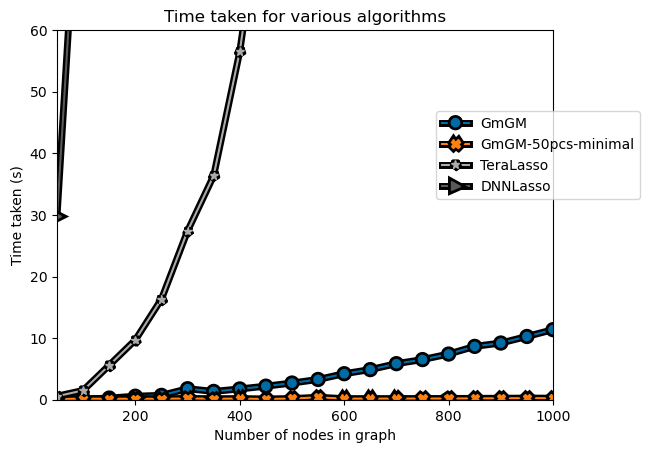

In [ ]:
fig, ax = plt.subplots()
linestyles = [(5,2),(2,5),(4,6),(3,3,2,2),(5,2,20,2)]
markers = ["o", "X", "*", ">", "<"]
for i, (algorithm, times) in enumerate(results_pw.items()):
    ax.plot(
        out_sizes_pw,
        times,
        label=algorithm,
        #linestyle="--",
        #dashes=linestyles[i],
        path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()],
        marker=markers[i]
    )
# ax.plot(
#     out_sizes_pw,
#     generator_results_pw,
#     label="Data generation",
#     color="#DDDDDD",
#     linestyle=":",
#     path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()]
# )
ax.set_xlabel("Number of nodes in graph")
ax.set_ylabel("Time taken (s)")
ax.set_title("Time taken for various algorithms")
ax.set_ylim(0, 60)
ax.set_xlim(out_sizes_pw[0], out_sizes_pw[-1])
ax.legend(bbox_to_anchor=(0.75, 0.8))

In [ ]:
# Note that `to_keep`==1 means keep one edge per node (i.e. N edges)
# but `to_keep`==1.0 means keep 100% of edges (i.e. N^2 edges)
algorithms = {
    "GmGM": lambda x: _gmgm_alg(x, None, 1.0),
    "GmGM-1000pcs": lambda x: _gmgm_alg(x, 1000, 1.0),
    "GmGM-50pcs": lambda x: _gmgm_alg(x, 50, 1.0),
    "GmGM-50pcs-minimal": lambda x: _gmgm_alg(x, 50, 1),
    #"Graphical Lasso": lambda x: _glasso_alg(x, 0),
}

In [ ]:
sizes = [
    500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000,
    5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000
]
results_gmgm, generator_results_gmgm, out_sizes_gmgm = time_algorithm(
    sizes,
    algorithms,
    num_trials=1
)

Size: 500, Generate Time: 0.06707358360290527


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 2.7307469844818115
	Algorithm: GmGM-1000pcs, Time: 1.109665870666504
	Algorithm: GmGM-50pcs, Time: 0.2561662197113037
	Algorithm: GmGM-50pcs-minimal, Time: 0.12862586975097656
Size: 1000, Generate Time: 0.3883819580078125


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 11.711556673049927
	Algorithm: GmGM-1000pcs, Time: 2.4481678009033203
	Algorithm: GmGM-50pcs, Time: 0.48274922370910645
	Algorithm: GmGM-50pcs-minimal, Time: 0.23041701316833496
Size: 1500, Generate Time: 1.2110521793365479


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 26.18380308151245
	Algorithm: GmGM-1000pcs, Time: 4.3843138217926025
	Algorithm: GmGM-50pcs, Time: 1.0720460414886475
	Algorithm: GmGM-50pcs-minimal, Time: 0.34297895431518555
Size: 2000, Generate Time: 3.7446208000183105


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 47.02700185775757
	Algorithm: GmGM-1000pcs, Time: 7.764540195465088
	Algorithm: GmGM-50pcs, Time: 1.8794193267822266
	Algorithm: GmGM-50pcs-minimal, Time: 0.4899930953979492
Size: 2500, Generate Time: 7.699783086776733


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:227: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Algorithm: GmGM, Time: 74.34159994125366
		GmGM took longer than a minute; skipping future runs
	Algorithm: GmGM-1000pcs, Time: 10.754263639450073
	Algorithm: GmGM-50pcs, Time: 3.6653640270233154
	Algorithm: GmGM-50pcs-minimal, Time: 0.7582159042358398
Size: 3000, Generate Time: 12.092157125473022
	Algorithm: GmGM-1000pcs, Time: 11.723664999008179
	Algorithm: GmGM-50pcs, Time: 5.503082990646362
	Algorithm: GmGM-50pcs-minimal, Time: 0.903411865234375
Size: 3500, Generate Time: 19.838931798934937
	Algorithm: GmGM-1000pcs, Time: 16.177414178848267
	Algorithm: GmGM-50pcs, Time: 8.040273189544678
	Algorithm: GmGM-50pcs-minimal, Time: 1.1282720565795898
Size: 4000, Generate Time: 28.080407857894897
	Algorithm: GmGM-1000pcs, Time: 19.454010009765625
	Algorithm: GmGM-50pcs, Time: 10.448058128356934
	Algorithm: GmGM-50pcs-minimal, Time: 1.3814480304718018
Size: 4500, Generate Time: 41.94915413856506
	Algorithm: GmGM-1000pcs, Time: 25.417773962020874
	Algorithm: GmGM-50pcs, Time: 15.33165407180

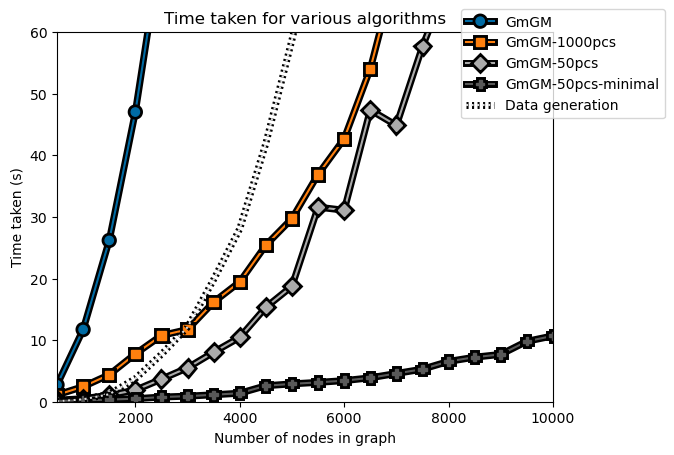

In [ ]:
fig, ax = plt.subplots()
linestyles = [(5,2),(2,5),(4,6),(3,3,2,2),(5,2,20,2)]
markers = ["o", "s", "D", "P", "X"]
for i, (algorithm, times) in enumerate(results_gmgm.items()):
    ax.plot(
        out_sizes_gmgm,
        times,
        label=algorithm,
        #linestyle="--",
        #dashes=linestyles[i],
        path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()],
        marker=markers[i]
    )
ax.plot(
    out_sizes_gmgm,
    generator_results_gmgm,
    label="Data generation",
    color="#DDDDDD",
    linestyle=":",
    path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()]
)
ax.set_xlabel("Number of nodes in graph")
ax.set_ylabel("Time taken (s)")
ax.set_title("Time taken for various algorithms")
ax.set_ylim(0, 60)
ax.set_xlim(out_sizes_gmgm[0], out_sizes_gmgm[-1])
ax.legend(bbox_to_anchor=(0.8, 1.08))

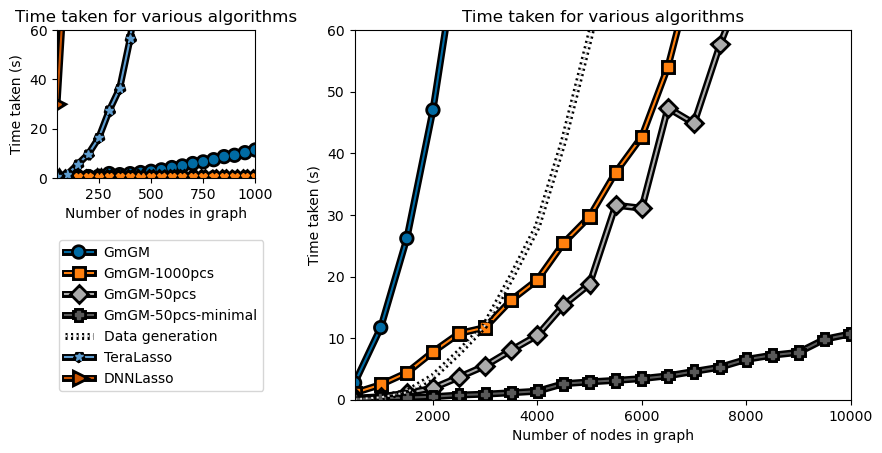

In [ ]:
fig, ax = plt.subplots()
linestyles = [(5,2),(2,5),(4,6),(3,3,2,2),(5,2,20,2)]
markers = ["o", "s", "D", "P", "X"]
for i, (algorithm, times) in enumerate(results_gmgm.items()):
    ax.plot(
        out_sizes_gmgm,
        times,
        label=algorithm,
        #linestyle="--",
        #dashes=linestyles[i],
        path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()],
        marker=markers[i]
    )
ax.plot(
    out_sizes_gmgm,
    generator_results_gmgm,
    label="Data generation",
    color="#DDDDDD",
    linestyle=":",
    path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()]
)
ax.set_xlabel("Number of nodes in graph")
ax.set_ylabel("Time taken (s)")
ax.set_title("Time taken for various algorithms")
ax.set_ylim(0, 60)
ax.set_xlim(out_sizes_gmgm[0], out_sizes_gmgm[-1])

# Draw a zoom-in
axins = ax.inset_axes(
    [-0.6, 0.6, 0.4, 0.4],
    #transform=ax.transData
)


linestyles = [(5,2),(2,5),(4,6),(3,3,2,2),(5,2,20,2)]
markers = ["o", "X", "*", ">", "<"]
for i, (algorithm, times) in enumerate(results_pw.items()):
    color = None
    if algorithm not in results_gmgm.keys():
        # Add to legend
        p = ax.plot(
            -1,
            -1,
            label=algorithm,
            path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()],
            marker=markers[i]
        )
        color = p[0].get_color()

    axins.plot(
        out_sizes_pw,
        times,
        #linestyle="--",
        #dashes=linestyles[i],
        path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()],
        marker=markers[i],
        color=color
    )

axins.set_xlabel("Number of nodes in graph")
axins.set_ylabel("Time taken (s)")
axins.set_title("Time taken for various algorithms")
axins.set_ylim(0, 60)
axins.set_xlim(out_sizes_pw[0], out_sizes_pw[-1])

ax.legend(bbox_to_anchor=(-0.17, 0.45))
fig.savefig("./out-figs/gmgm-runtimes.pdf", bbox_inches="tight")
pass

## GmGM Runtime Breakdown

This codeblock is a copy-and-paste of the GmGM algorithm, so that we can insert runtime-measuring hooks into it in a programmatically convenient way!

An alternative would be to use line_profiler (a very useful tool), but it is not as easy to extract the results in a machine-friendly way.

In [ ]:
"""
This file wraps the core functionality of the GmGM algorithm into a single function.
"""
from __future__ import annotations

# Import core functionality of GmGM
from GmGM.core.core import direct_svd, direct_left_eigenvectors
from GmGM.core.core import nonparanormal_left_eigenvectors
from GmGM.core.core import calculate_eigenvalues, calculate_eigenvectors
from GmGM.core.core import recompose_dense_precisions
from GmGM.core.preprocessing import center, clr_prost, create_gram_matrices
from GmGM.core.presparse_methods import recompose_sparse_precisions

# Used for typing
from typing import Optional, Literal
from GmGM.extras.prior import Prior
from GmGM.typing import Axis, MaybeDict
from GmGM.dataset import Dataset
from GmGM.extras.regularizers import Regularizer
try:
    from anndata import AnnData
except ImportError:
    AnnData = None
try:
    from mudata import MuData
except ImportError:
    MuData = None

# For warnings
import warnings
from numbers import Real

# For checking sparsity
import scipy.sparse as sparse

def _timing_GmGM(
    dataset: Dataset | AnnData,
    to_keep: Optional[MaybeDict[Axis, float | int]] = None,
    random_state: Optional[int] = None,
    batch_size: Optional[int] = None,
    verbose: bool = False,
    print_memory_usage: bool = False,
    # `center` parameters
    centering_method: Optional[Literal["avg-overall", "clr-prost"]] = None,
    # `create_gram_matrices` parameters
    use_nonparanormal_skeptic: bool = False,
    nonparanormal_evec_backend: Optional[Literal["COCA", "XPCA"]] = None,
    # `calculate_eigenvectors` parameters
    n_comps: Optional[int] = None,
    calculate_explained_variance: bool = True,
    # `calculate_eigenvalues` parameters
    max_small_steps: int = 5,
    max_line_search_steps: int = 20,
    lr_init: float = 1.0,
    max_iter: int = 1000,
    tol: float = 1e-3,
    regularizer: Optional[Regularizer] = None,
    force_posdef: bool = True,
    verbose_every: int = 100,
    always_regularize: bool = False,
    check_overstep_each_iter: bool = False,
    # `recompose_sparse_positions` parameters
    threshold_method: MaybeSet[Literal[
        "overall",
        "overall-col-weighted",
        "rowwise",
        "rowwise-col-weighted",
        "nonsingleton-percentage"
    ]] = "overall",
    min_edges: int = 0,
    dont_recompose: Optional[set[Axis]] | bool = None,
    # from_AnnData/MuData parameters
    use_highly_variable: bool = False,
    key_added: str = "gmgm",
    use_abs_of_graph: bool = True,
    key_map: Optional[dict[Axis, Axis]] = None,
    readonly: bool = True,
    prior: Optional[dict[Axis, Prior]] = None,
    # Parameters to force a specific compute path
    _assume_sparse: bool = False,
) -> tuple[float, float, float, float]:
    """
    Performs GmGM on the given dataset.

    `_force_sparse`: If true, will force algorithm to treat the dataset as sparse
    """
    # Convert AnnData/MuData to Dataset (if relevant)
    start = time.time()
    is_anndata: bool = AnnData is not None and isinstance(dataset, AnnData)
    is_mudata: bool = MuData is not None and isinstance(dataset, MuData)
    if is_anndata:
        _dataset = Dataset.from_AnnData(dataset, use_highly_variable=use_highly_variable)
        if prior is not None:
            _dataset.prior = prior
    elif is_mudata:
        _dataset = Dataset.from_MuData(dataset, use_highly_variable=use_highly_variable)
        if prior is not None:
            _dataset.prior = prior
    else:
        _dataset = dataset
        if prior is not None:
            raise ValueError(
                "Cannot specify `prior` if `dataset` is a Dataset.\n"
                + "Add it directly to the Dataset instead."
            )

    if readonly:
        _dataset.make_readonly()
        
    if nonparanormal_evec_backend is not None and not use_nonparanormal_skeptic:
        warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")

    # Save the random state
    _dataset.random_state = random_state

    # Expand `to_keep` if necessary
    # First expand if it's a single value
    if isinstance(to_keep, Real):
        to_keep = {axis: to_keep for axis in _dataset.all_axes}

    if key_map is not None:
        for key, value in key_map.items():
            if key in to_keep.keys():
                to_keep[value] = to_keep[key]
            else:
                warnings.warn(f"`key_map` has {key}:{value} but {value} not in `to_keep`!")

    # If `dont_recompose` is a bool and true, then set it to all axes
    if dont_recompose is True:
        dont_recompose = _dataset.all_axes.copy()

    # Center dataset
    if verbose:
        print("Centering...")
    if centering_method == "clr-prost":
        if is_anndata or is_mudata:
            if 'log1p' in dataset.uns.keys():
                warnings.warn(
                    "Dataset was log1p-transformed; clr-prost expects raw compositional (such as count) data"
                )
        clr_prost(_dataset)
    elif centering_method == "avg-overall":
        center(_dataset)
    elif centering_method is None:
        pass
    else:
        raise ValueError(f"Invalid centering method: {centering_method}")
    
    end = time.time()
    preprocessing_time = end - start
    start = time.time()

    # Calculate eigenvectors
    if verbose:
        print("Calculating eigenvectors...")


    # Check properties of dataset to find the best way to calculate eigenvectors
    unimodal: bool = len(_dataset.dataset) == 1
    sparseness = [
        _assume_sparse or sparse.issparse(_dataset.dataset[key])
        for key in _dataset.dataset.keys()
    ]
    allsparse = all(sparseness)
    anysparse = any(sparseness)

    if anysparse and not allsparse:
        warnings.warn(
            "Some axes are sparse, but not all. This is a hard case to account for,"
            + " and will likely lead to densification or slower performance (or both)."
        )

    # Assume that anything without a `ndim` attribute is a matrix
    matrix_variate: bool = all([
        not hasattr(_dataset.dataset[key], "ndim") or _dataset.dataset[key].ndim == 2
        for key in _dataset.dataset.keys()
    ])

    # If dataset is a single matrix, then we can do SVD on said matrix
    # to get the eigenvectors for both axes at once
    # (But under the nonparanormal skeptic, this trick wouldn't work)
    if unimodal and matrix_variate and n_comps is not None and not use_nonparanormal_skeptic:
        if verbose:
            print("\tby calculating SVD...")
        direct_svd(
            _dataset,
            n_comps=n_comps,
            random_state=random_state,
            calculate_explained_variance=calculate_explained_variance,
            verbose=verbose
        )
    # If dataset is a single matrix, but we want to use the nonparanormal skeptic,
    # we can do it similarly to direct_left_eigenvectors, using a rank-one update trick.
    # TODO: The trick would also work in the multi-modal case, but it is harder to
    # get sparse matrices to work with dask, so I have deferred that to later
    # TODO: This works in the tensor-variate case, but needs a more flexible library than
    # scipy.sparse, which limits us to 2D matrices
    elif unimodal and matrix_variate and n_comps is not None and use_nonparanormal_skeptic and allsparse:
        if verbose:
            print("\tby calculating left eigenvectors and applying a rank-one update...")
        nonparanormal_left_eigenvectors(
            _dataset,
            n_comps=n_comps,
            nonparanormal_evec_backend=nonparanormal_evec_backend,
            random_state=random_state,
            calculate_explained_variance=calculate_explained_variance,
            verbose=verbose,
        )
    # If dataset is multi-modal or tensor-variate, we can find the left
    # eigenvectors of the concatenation of the matricization of each modality
    # on a given axis
    elif n_comps is not None:
        if verbose:
            print("\tby calculating left eigenvectors of concatenated matricizations...")
        direct_left_eigenvectors(
            _dataset,
            n_comps=n_comps,
            use_nonparanormal_skeptic=use_nonparanormal_skeptic,
            nonparanormal_evec_backend=nonparanormal_evec_backend,
            random_state=random_state,
            calculate_explained_variance=calculate_explained_variance,
            verbose=verbose
        )
    # If `n_comps` is not specified, we do it the old way, which is
    # an O(n^2) memory operation!
    # TODO: Update old way to still only keep min(n, m) eigenvectors/values
    # since the rest are useless (correspond to 0 eigenvalues) and
    # in fact are detrimental due to MLE existance reasons
    else:
        if verbose:
            print("\tby calculating gram matrices and then eigendecomposing...")
        warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")
        # Create Gram matrices
        create_gram_matrices(
            _dataset,
            use_nonparanormal_skeptic=use_nonparanormal_skeptic,
            batch_size=batch_size
        )

        # Calculate eigenvectors
        calculate_eigenvectors(
            _dataset,
            n_comps=n_comps,
            random_state=random_state,
            verbose=verbose
        )

        if verbose and calculate_explained_variance:
            print(f"100% explained variance, since `n_comps` was not specified")

    end = time.time()
    eigenvector_time = end - start
    start = time.time()

    # Calculate eigenvalues
    if verbose:
        print("Calculating eigenvalues...")
    calculate_eigenvalues(
        _dataset,
        max_small_steps=max_small_steps,
        max_line_search_steps=max_line_search_steps,
        lr_init=lr_init,
        max_iter=max_iter,
        tol=tol,
        regularizer=regularizer,
        force_posdef=force_posdef,
        verbose=verbose,
        verbose_every=verbose_every,
        always_regularize=always_regularize,
        check_overstep_each_iter=check_overstep_each_iter,
    )

    end = time.time()
    eigenvalue_time = end - start
    start = time.time()

    # Recompose sparse precisions
    if to_keep is not None:
        if verbose:
            print("Recomposing sparse precisions...")
        recompose_sparse_precisions(
            _dataset,
            to_keep=to_keep,
            threshold_method=threshold_method,
            min_edges=min_edges,
            batch_size=batch_size,
            dont_recompose=dont_recompose
        )
    else:
        if verbose:
            print("Recomposing dense precisions as to_keep was not specified...")
        recompose_dense_precisions(
            _dataset,
            dont_recompose=dont_recompose
        )

    end = time.time()
    recompose_time = end - start
        

    # Print memory usage (useful if directly used on `AnnData`/`MuData`)
    if print_memory_usage:
        print("Memory Usage: ")
        _dataset.print_memory_usage()

    # If was AnnData/MuData, return it
    if AnnData is not None and isinstance(dataset, AnnData):
        if verbose:
            print("Converting back to AnnData...")
        return _dataset.to_AnnData(
            key_added=key_added,
            use_abs_of_graph=use_abs_of_graph,
            key_map=key_map
        )
    elif MuData is not None and isinstance(dataset, MuData):
        if verbose:
            print("Converting back to MuData...")
        return _dataset.to_MuData(
            key_added=key_added,
            use_abs_of_graph=use_abs_of_graph,
            key_map=key_map
        )
    
    if verbose:
        print("Done!")

    if readonly:
        _dataset.unmake_readonly()
    
    # Otherwise, return a Dataset object
    return preprocessing_time, eigenvector_time, eigenvalue_time, recompose_time

Now, we run the actual test.

In [ ]:
def GmGM_timing_breakdown(
    sizes: list[int],
    nonpara: bool,
    sparsity: Optional[float] = None
) -> np.ndarray:
    """
    Inputs:
        size: Number of nodes
        algorithm: Algorithm to time
        num_trials: Number of trials

    Outputs:
        time: Average time taken
    """
    output = np.zeros((len(sizes), 5))
    for idx, size in enumerate(sizes):
        data = generate_data_for_runtimes(size, sparsity=sparsity)
        if data.ndim == 3:
            data = GmGM.Dataset(
                dataset={"data": data},
                structure={"data": ("", "rows", "columns")}
            )
        elif data.ndim == 2:
            data = GmGM.Dataset(
                dataset={"data": data},
                structure={"data": ("rows", "columns")}
            )

        n_comps = 50

        if sparsity is not None and n_comps >= size:
            # Sparse SVD does not allow full-rank decompositions
            n_comps = size - 1

        (
            preprocessing,
            eigenvector,
            eigenvalue,
            recompose
        ) = _timing_GmGM(
            data,
            to_keep=1,
            threshold_method="overall-col-weighted",
            n_comps=n_comps,
            verbose=False,
            centering_method=None,
            use_nonparanormal_skeptic=nonpara,
            readonly=False,
            calculate_explained_variance=True,
            batch_size=1000
        )
        total = preprocessing + eigenvector + eigenvalue + recompose
        preprocessing = preprocessing / total
        eigenvector = eigenvector / total
        eigenvalue = eigenvalue / total
        recompose = recompose / total
        
        print(
            f"Size: {size}:\n\tPreprocessing: {preprocessing}\n\tEigenvector: {eigenvector}\n\t"
            + f"Eigenvalue: {eigenvalue}\n\tRecompose: {recompose}\n\tTotal: {total}"
        )

        output[idx, :] = [preprocessing, eigenvector, eigenvalue, recompose, total]

    return output

In [ ]:
sizes = [
    30, 100, 300, 1000, 3000, 10000,
]
print("==== without nonparanormal skeptic ====")
breakdown_output = GmGM_timing_breakdown(sizes, nonpara=False)

==== without nonparanormal skeptic ====
Size: 30:
	Preprocessing: 0.0016399938214810984
	Eigenvector: 0.8961820782657166
	Eigenvalue: 0.0752812233467425
	Recompose: 0.026896704566059783
	Total: 0.1775062084197998
Size: 100:
	Preprocessing: 3.251959305481553e-05
	Eigenvector: 0.6429223607223352
	Eigenvalue: 0.3363351419230086
	Recompose: 0.020709977761601366
	Total: 0.09530997276306152
Size: 300:
	Preprocessing: 7.078856314232577e-05
	Eigenvector: 0.9489850421620972
	Eigenvalue: 0.011040870742228811
	Recompose: 0.039903298532531634
	Total: 0.1111452579498291
Size: 1000:
	Preprocessing: 0.0012467927343819576
	Eigenvector: 0.8876813652170071
	Eigenvalue: 0.003229880390643024
	Recompose: 0.10784196165796787
	Total: 0.3399989604949951
Size: 3000:
	Preprocessing: 8.549609698551743e-05
	Eigenvector: 0.7605782464462907
	Eigenvalue: 0.0016688733549191368
	Recompose: 0.23766738410180469
	Total: 0.9118881225585938
Size: 10000:
	Preprocessing: 0.00022115690066186868
	Eigenvector: 0.782004418709665

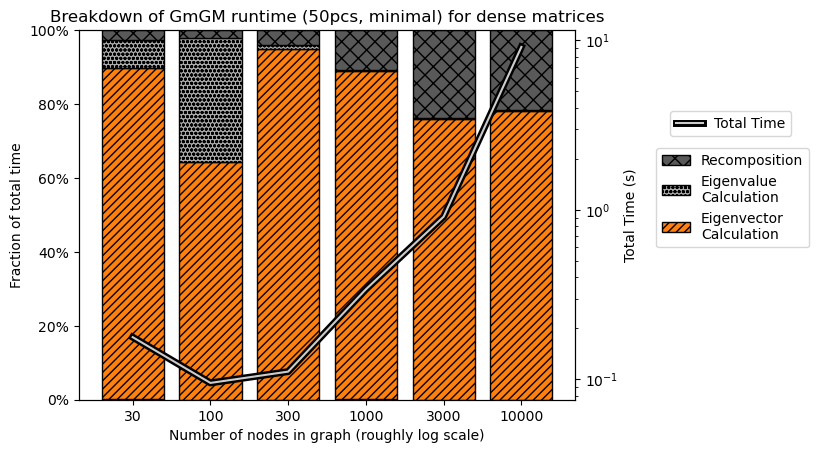

In [ ]:
fig, ax = plt.subplots()

# Do a bar plot for output[:, :4]
for i, label in enumerate([
    "Preprocessing",
    "Eigenvector\nCalculation",
    "Eigenvalue\nCalculation",
    "Recomposition"
]):
    bar = ax.bar(
        x=np.arange(len(sizes)),
        height=breakdown_output[:, i],
        label=label,
        bottom=np.sum(breakdown_output[:, :i], axis=1),
        hatch=hatches[i]*2,
        edgecolor="black"
    )

ax.set_xticks(
    np.arange(len(sizes)),
)
ax.set_xticklabels(sizes)
ax.set_ylim(0, 1)

ax.set_ylabel("Fraction of total time")
ax.set_xlabel("Number of nodes in graph (roughly log scale)")

ax.set_title("Breakdown of GmGM runtime (50pcs, minimal) for dense matrices")

# Format y axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Plot total time as a line
ax2 = ax.twinx()
ax2.plot(
    np.arange(len(sizes)),
    breakdown_output[:, 4],
    color="#CCCCCC",
    label="Total Time",
    linestyle="-",
    path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()]
)
ax2.set_ylabel("Total Time (s)")
#ax2.set_ylim(0, breakdown_output[:, 4].max() * 1.1)

ax.legend(bbox_to_anchor=(1.15, 0.7))

# Remove preprocessing from the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], bbox_to_anchor=(1.15, 0.7), reverse=True)

ax2.legend(bbox_to_anchor=(1.45, 0.8))
ax2.set_yscale('log')
fig.savefig("./out-figs/gmgm-breakdown.pdf", bbox_inches="tight")
pass

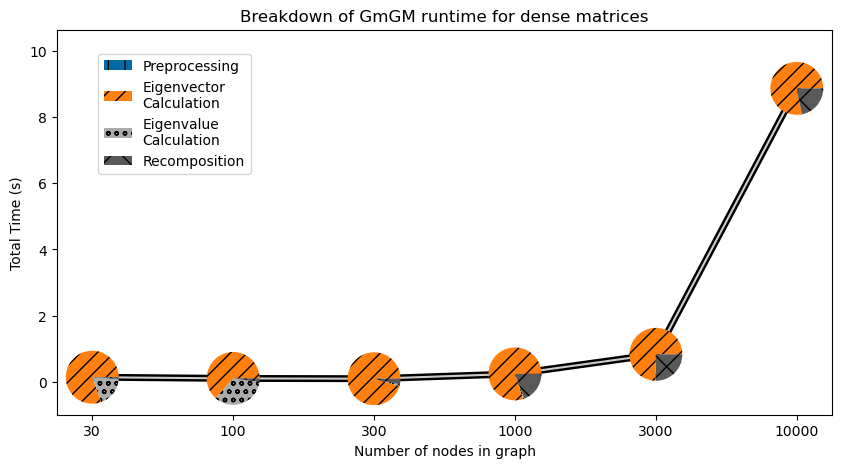

In [ ]:
# # Scatter pie chart (just for fun)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    np.arange(len(sizes)),
    breakdown_output[:, 4],
    color="#CCCCCC",
    label="Total Time",
    linestyle="-",
    path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()]
)

# Inset axes

for i in range(len(sizes)):
    axins = ax.inset_axes(
        [-1+i, breakdown_output[i, 4]-1, 2, 2],
        transform=ax.transData
    )
    axins.pie(
        breakdown_output[i, :4],
        labels=[
            "Preprocessing",
            "Eigenvector\nCalculation",
            "Eigenvalue\nCalculation",
            "Recomposition"
        ],
        labeldistance=1.2,
        #wedgeprops=dict(width=0.3, edgecolor='w'),
        center=(0, 0),
        textprops={'fontsize': 0, 'color': "#00000000"},
        colors=[f"C{i}" for i in range(4)],
        hatch=hatches[:4]*2,
    )
    if i == 0:
        axins.legend(bbox_to_anchor=(3, 5.5))

ax.set_xlabel("Number of nodes in graph")
ax.set_ylabel("Total Time (s)")
ax.set_title("Breakdown of GmGM runtime for dense matrices")
ax.set_ylim(-1, breakdown_output[:, 4].max() * 1.2)

ax.set_xticks(np.arange(len(sizes)))
ax.set_xticklabels(sizes)

pass

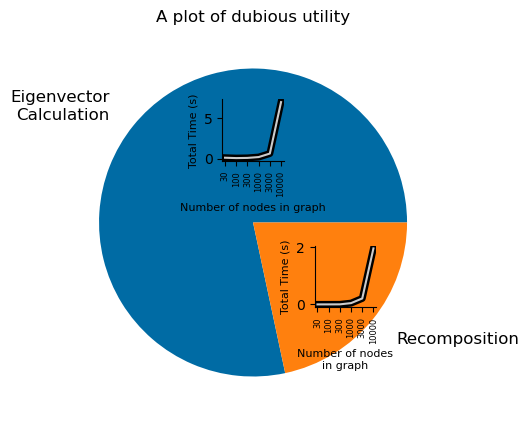

In [ ]:
# Just for fun 2

fig, ax = plt.subplots(figsize=(10, 5))
breakdown_output_fun = breakdown_output.copy()[:, [1, 3]]
breakdown_output_fun *= breakdown_output[:, 4].reshape(-1, 1)

ax.pie(
    breakdown_output_fun.sum(axis=0),
    labels=[
        "Eigenvector\nCalculation",
        "Recomposition"
    ],
    labeldistance=1.2,
    center=(0, 0),
    textprops={'fontsize': 12},
    colors=[f"C{i}" for i in range(2)] * 2,
)

# Add inset
axins = ax.inset_axes(
    [-0.2, 0.4, 0.4, 0.4],
    transform=ax.transData
)
axins.plot(
    np.arange(len(sizes)),
    breakdown_output_fun[:, 0],
    color="#CCCCCC",
    label="Total Time",
    linestyle="-",
    path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()]
)
# Remove background
axins.set_facecolor("#FFFFFF00")

# Remove top and right edges
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)

axins.set_xlabel("Number of nodes in graph", fontdict={'fontsize': 8})
axins.set_ylabel("Total Time (s)", fontdict={'fontsize': 8})

axins.set_xticks(np.arange(len(sizes)))
axins.set_xticklabels(sizes, rotation=90, fontdict={'fontsize': 6})

# Add inset for next set
axins = ax.inset_axes(
    [0.4, -0.55, 0.4, 0.4],
    transform=ax.transData
)
axins.plot(
    np.arange(len(sizes)),
    breakdown_output_fun[:, 1],
    color="#CCCCCC",
    label="Total Time",
    linestyle="-",
    path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()]
)
# Remove background
axins.set_facecolor("#FFFFFF00")

# Remove top and right edges
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)

axins.set_xlabel("Number of nodes\nin graph", fontdict={'fontsize': 8})
axins.set_ylabel("Total Time (s)", fontdict={'fontsize': 8})

axins.set_xticks(np.arange(len(sizes)))
axins.set_xticklabels(sizes, rotation=90, fontdict={'fontsize': 6})

ax.set_title("A plot of dubious utility")

pass

In [ ]:
sizes = [
    30, 100, 300, 1000, 3000, 10000,
]
print("==== sparse, without nonparanormal skeptic ====")
breakdown_output_sparse = GmGM_timing_breakdown(sizes, nonpara=False, sparsity=0.9)

==== sparse, without nonparanormal skeptic ====
Size: 30:
	Preprocessing: 0.003245795219828858
	Eigenvector: 0.2476063532117093
	Eigenvalue: 0.5698151219462562
	Recompose: 0.17933272962220573
	Total: 0.023432016372680664
Size: 100:
	Preprocessing: 0.0006422214746628337
	Eigenvector: 0.6753417535704456
	Eigenvalue: 0.1958775497721643
	Recompose: 0.1281384751827273
	Total: 0.007796049118041992
Size: 300:
	Preprocessing: 0.00021441261154560862
	Eigenvector: 0.7226215515304977
	Eigenvalue: 0.11884584754242307
	Recompose: 0.15831818831553368
	Total: 0.023351192474365234
Size: 1000:
	Preprocessing: 3.130520337201762e-05
	Eigenvector: 0.7426578117662843
	Eigenvalue: 0.009103851285376743
	Recompose: 0.24820703174496694
	Total: 0.15993475914001465
Size: 3000:
	Preprocessing: 4.6941395771648564e-05
	Eigenvector: 0.853590434055756
	Eigenvalue: 0.0014406152495436972
	Recompose: 0.14492200929892862
	Total: 1.4729299545288086
Size: 10000:
	Preprocessing: 2.4209000012620328e-05
	Eigenvector: 0.934737

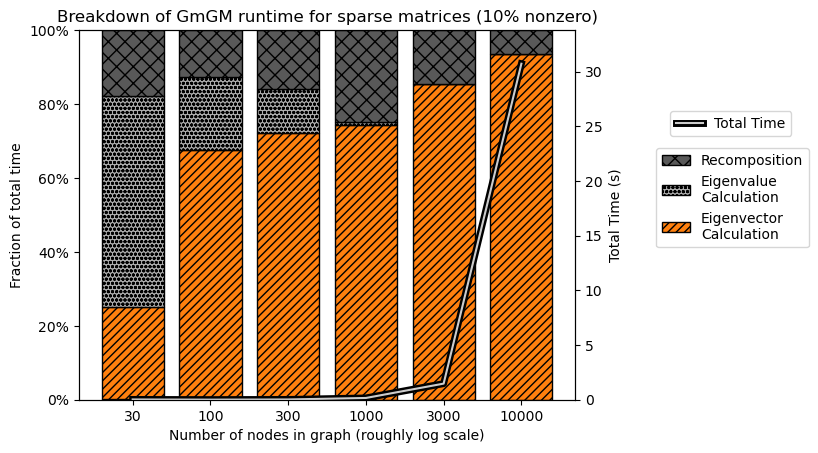

In [ ]:
fig, ax = plt.subplots()

# Do a bar plot for output[:, :4]
for i, label in enumerate([
    "Preprocessing",
    "Eigenvector\nCalculation",
    "Eigenvalue\nCalculation",
    "Recomposition"
]):
    bar = ax.bar(
        x=np.arange(len(sizes)),
        height=breakdown_output_sparse[:, i],
        label=label,
        bottom=np.sum(breakdown_output_sparse[:, :i], axis=1),
        hatch=hatches[i]*2,
        edgecolor="black"
    )

ax.set_xticks(
    np.arange(len(sizes)),
)
ax.set_xticklabels(sizes)
ax.set_ylim(0, 1)

ax.set_ylabel("Fraction of total time")
ax.set_xlabel("Number of nodes in graph (roughly log scale)")

ax.set_title("Breakdown of GmGM runtime for sparse matrices (10% nonzero)")

# Format y axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Plot total time as a line
ax2 = ax.twinx()
ax2.plot(
    np.arange(len(sizes)),
    breakdown_output_sparse[:, 4],
    color="#CCCCCC",
    label="Total Time",
    linestyle="-",
    path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()]
)
ax2.set_ylabel("Total Time (s)")
ax2.set_ylim(0, breakdown_output_sparse[:, 4].max() * 1.1)

ax.legend(bbox_to_anchor=(1.15, 0.7))

# Remove preprocessing from the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], bbox_to_anchor=(1.15, 0.7), reverse=True)

ax2.legend(bbox_to_anchor=(1.45, 0.8))
pass